In [2]:
import numpy as np
import pandas as pd
import pvlib

# Golden, CO
latitude, longitude = 39.76, -105.22
tz = 'MST'

# Set times in the morning of the December solstice.
times = pd.date_range(
    '2020-12-20 6:30', '2020-12-20 9:00', freq='1T', tz=tz
)

# Create location object, and get solar position and clearsky irradiance data.
location = pvlib.location.Location(latitude, longitude, tz)
solar_position = location.get_solarposition(times)
clearsky = location.get_clearsky(times)

# Assign variable names for easier reading.
surface_tilt = 30
surface_azimuth = 180
solar_azimuth = solar_position.azimuth
solar_zenith = solar_position.apparent_zenith
solar_elevation = solar_position.apparent_elevation
dni = clearsky.dni
ghi = clearsky.ghi
dhi = clearsky.dhi

/tmp/ipykernel_84407/3168085322.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  times = pd.date_range(


Text(0, 0.5, 'Horizon angle [°]')

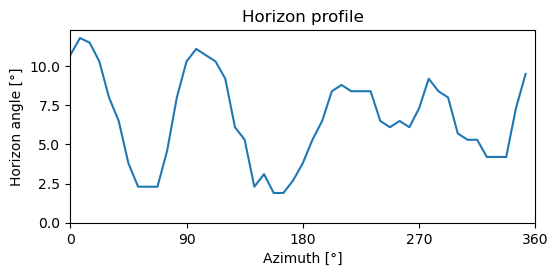

In [3]:
# Use hard-coded horizon profile data from location object above.
horizon_profile = pd.Series([
    10.7, 11.8, 11.5, 10.3, 8.0, 6.5, 3.8, 2.3, 2.3, 2.3, 4.6, 8.0, 10.3, 11.1,
    10.7, 10.3, 9.2, 6.1, 5.3, 2.3, 3.1, 1.9, 1.9, 2.7, 3.8, 5.3, 6.5, 8.4,
    8.8, 8.4, 8.4, 8.4, 6.5, 6.1, 6.5, 6.1, 7.3, 9.2, 8.4, 8.0, 5.7, 5.3, 5.3,
    4.2, 4.2, 4.2, 7.3, 9.5
], index=np.arange(0, 360, 7.5))

ax = horizon_profile.plot(xlim=(0, 360), ylim=(0, None), figsize=(6, 2.5))
ax.set_title('Horizon profile')
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_xlabel('Azimuth [°]')
ax.set_ylabel('Horizon angle [°]')

<Axes: title={'center': 'DNI: Before and after Horizon Adjustment'}, ylabel='Irradiance'>

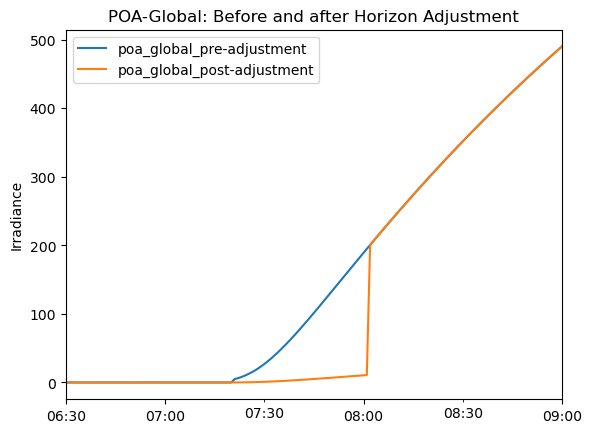

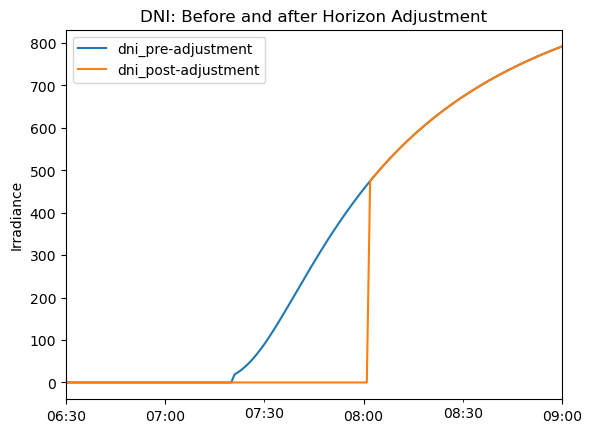

In [4]:
# Interpolate the horizon elevation data to the solar azimuth, and keep as a
# numpy array.
horizon_elevation_data = np.interp(
    solar_azimuth, horizon_profile.index, horizon_profile
)

# Convert to Pandas Series for easier usage.
horizon_elevation_data = pd.Series(horizon_elevation_data, times)

# Adjust DNI based on data - note this is returned as numpy array
dni_adjusted = np.where(solar_elevation > horizon_elevation_data, dni, 0)

# Adjust GHI and set it to DHI for time-periods where 'dni_adjusted' is 0.
# Note this is returned as numpy array
ghi_adjusted = np.where(dni_adjusted == 0, dhi, ghi)

# Transposition using the original and adjusted irradiance components.
irrad_pre_adj = pvlib.irradiance.get_total_irradiance(
    surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni, ghi, dhi
)

irrad_post_adj = pvlib.irradiance.get_total_irradiance(
    surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni_adjusted,
    ghi_adjusted, dhi
)

# Create and plot result DataFrames.
poa_global_comparison = pd.DataFrame({
    'poa_global_pre-adjustment': irrad_pre_adj.poa_global,
    'poa_global_post-adjustment': irrad_post_adj.poa_global
})

dni_comparison = pd.DataFrame({
    'dni_pre-adjustment': dni,
    'dni_post-adjustment': dni_adjusted
})

# Plot results
poa_global_comparison.plot(
    title='POA-Global: Before and after Horizon Adjustment',
    ylabel='Irradiance'
)
dni_comparison.plot(
    title='DNI: Before and after Horizon Adjustment', ylabel='Irradiance'
)